# USAGE: (just change the ticker and you're set)
#
# This notebook generates a comprehensive statistical and graphical analysis report
# on a stock price historical series (data from Yahoo Finance).
#
# SECTIONS:
#
# 1 – MONTHLY BOXPLOT
#     Distribution of average daily returns by month.
#     Useful for understanding if certain months are typically positive/negative
#     and how volatile they are.
#
# 2 – ADF TEST (Augmented Dickey–Fuller)
#     Verifies if the price follows a random walk or is stationary.
#     Distinction between persistent trend and mean reversion.
#
# 3 – DECOMPOSITION (STL + Residuals)
#     Decomposition of the series into trend and unexplained component.
#     Allows for isolating seasonality and sudden shocks.
#
# 4 – PRICE vs. SEASONALLY ADJUSTED
#     Comparison between the observed price and the one "cleaned" of seasonality.
#
# 5 – OCTOBER
#     Specific analysis of the month of October:
#       - descriptive statistics
#       - returns distribution
#       - comparison with other months
#       - regression on the annual return
#
# 6 – FAN CHART (YTD vs. History)
#     Comparison of the current year's performance with the historical distribution.
#     Shows typical ranges (10–90%, 25–75%) and median.
#
# 7 – DRAWDOWN vs. RETURN
#     - Bar plot: max drawdown and annual return
#     - Scatter plot: relationship between drawdown/final return
#     Verifies if deep drawdowns imply negative years.
#
# 8 – BEAR DAYS (< -19%)
#     Counts the days in a deep drawdown per year.
#     Identifies periods of a particularly weak market.
#
# 9 – SIMILAR YEARS (JAN–SEP + PROJECTION)
#     Comparison of January–September with the same months in other years.
#     Shows the "top similar years" and their closures from October to December.
#
# 10 – UP/DOWN TRANSITION MATRIX
#      Heatmap with conditional probabilities:
#      - P(Up|Up) = momentum
#      - P(Up|Down) = mean reversion
#
# 11 – PROBABILITY OF REBOUND AFTER DOWN-STREAK
#      Probability that a rise follows after 1, 2, 3… consecutive declines.
#
# 12 – SIGN AUTOCORRELATION
#      ACF on the signs (+1=up, –1=down).
#      Measures the persistence or reversal of returns.
#
# 13 – ROLLING CONDITIONAL PROBABILITIES
#      Dynamic curves P(Up|Up) and P(Up|Down) over rolling windows.
#      Distinguish between momentum and mean-reversion phases.
#
# 14 – NEW HIGHS (YTD)
#      Count of new annual highs and their relationship with performance.
#      Shows if more highs correspond to better annual returns.



In [1]:
pip install yfinance

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from matplotlib.backends.backend_pdf import PdfPages

from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf, adfuller
import statsmodels.api as sm
from scipy import stats
from datetime import datetime

plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.dpi"] = 130

In [3]:
def coerce_to_series(obj) -> pd.Series:
    """Series; se DataFrame: Close > Adj Close > prima colonna."""
    if isinstance(obj, pd.Series):
        s = obj.dropna()
        if not isinstance(s.index, pd.DatetimeIndex):
            s.index = pd.to_datetime(s.index)
        return s.sort_index()

    if isinstance(obj, pd.DataFrame):
        for c in ["Close", "Adj Close"]:
            if c in obj.columns:
                s = obj[c].dropna()
                if not isinstance(s.index, pd.DatetimeIndex):
                    s.index = pd.to_datetime(s.index)
                return s.sort_index()
        s = obj.iloc[:, 0].dropna().squeeze()
        if not isinstance(s.index, pd.DatetimeIndex):
            s.index = pd.to_datetime(s.index)
        return s.sort_index()

    s = pd.Series(obj).dropna()
    s.index = pd.to_datetime(s.index)
    return s.sort_index()

def ensure_end_date(end_date):
    return pd.Timestamp.today().normalize() if end_date in (None, "", "None") else pd.to_datetime(end_date)

def safe_title(txt):

    return "".join(ch if ch.isalnum() or ch in "-_." else "_" for ch in str(txt))

In [4]:
SYMBOL = "JPM"      # change ticker here!
START_DATE = "2000-01-01"
END_DATE = None

TOP_N_YEARS = 8
CORR_METHOD = "spearman"
OCT_THRESHOLD = 0.0005
ACF_LAGS = 20
ROLL_WIN = 252

JPM — obs: 6478 | 2000-01-03 → 2025-10-03


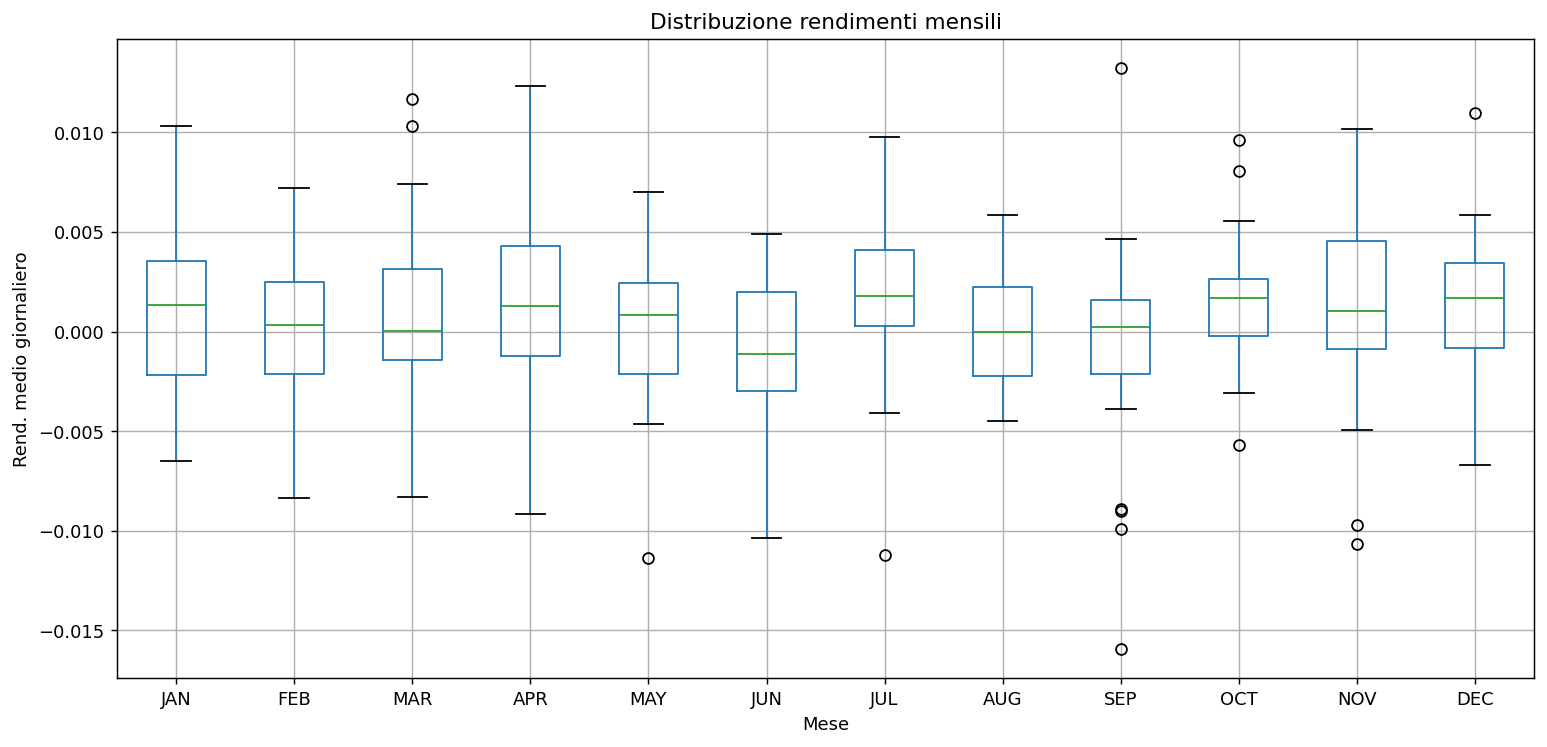


=== ADF su prezzi (JPM) ===
ADF: 4.108110 | p-value: 1.000000
 1%: -3.431
 5%: -2.862
 10%: -2.567


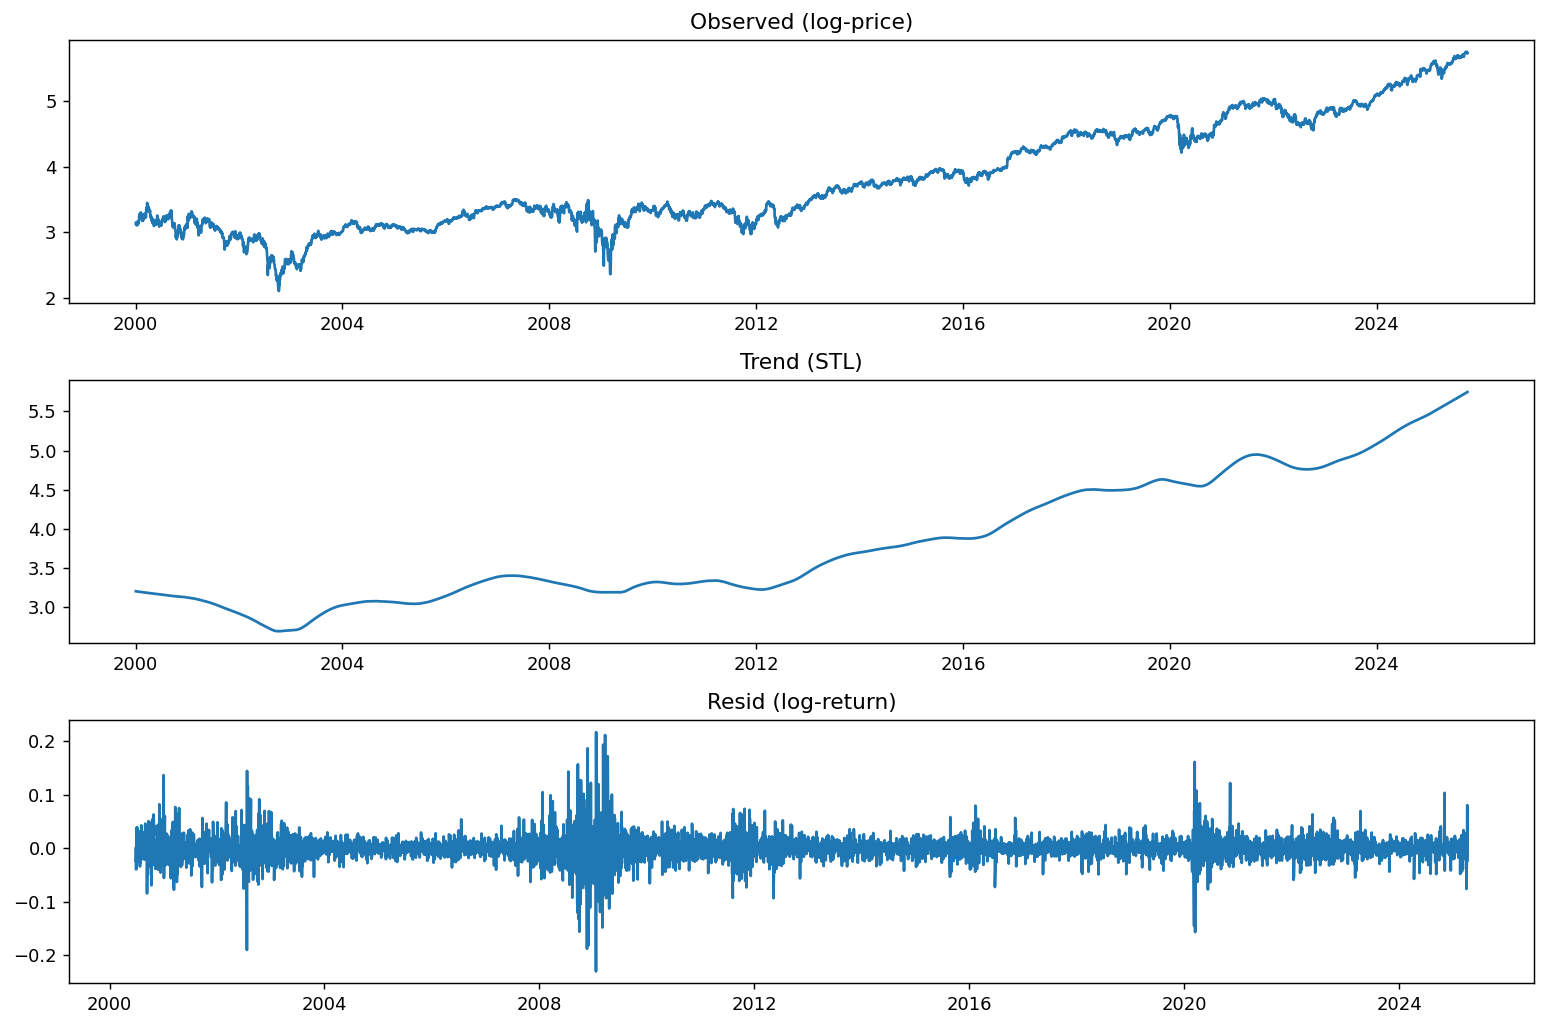

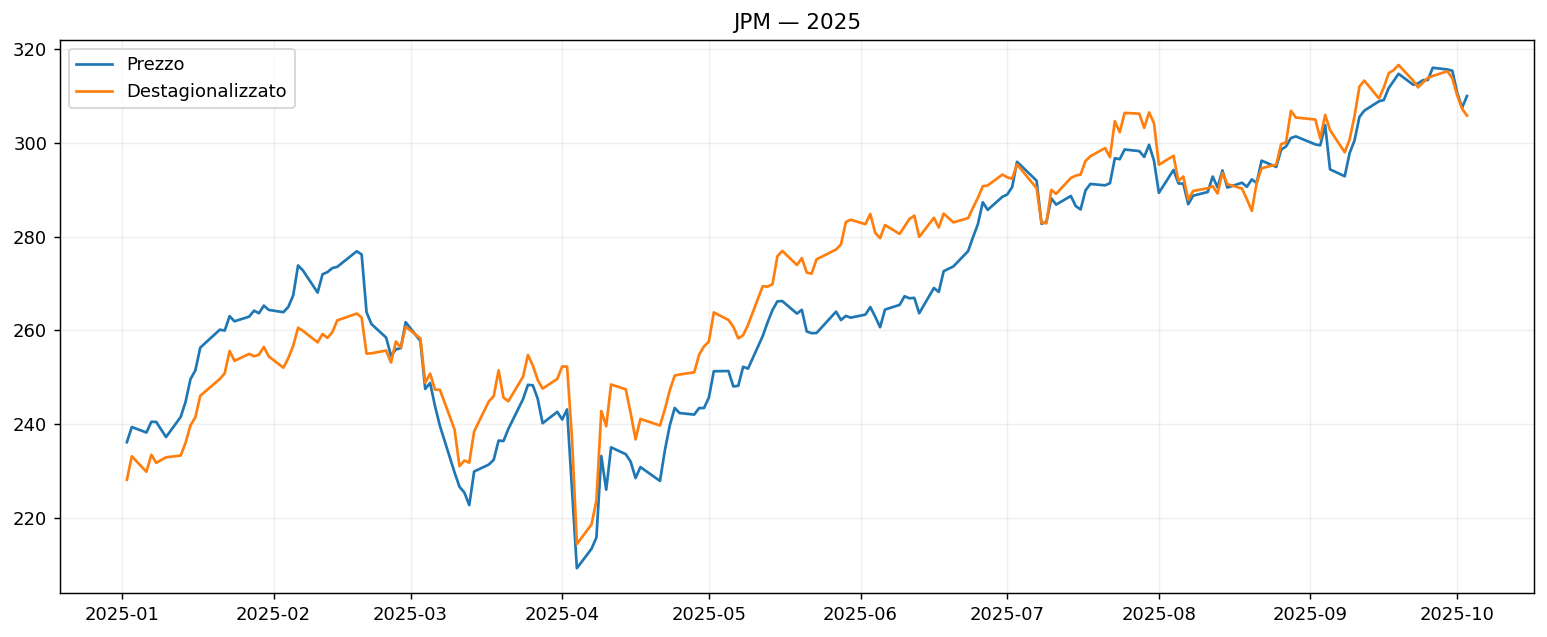


=== Ottobre: statistiche ===
count    26.000000
mean      0.037359
std       0.062013
min      -0.071212
25%      -0.004217
50%       0.036770
75%       0.059356
max       0.202159
Name: Oct_Return, dtype: float64
Hit rate (ottobre>0): 73.1%
Δ medio (Ott - media altri mesi): 0.0253


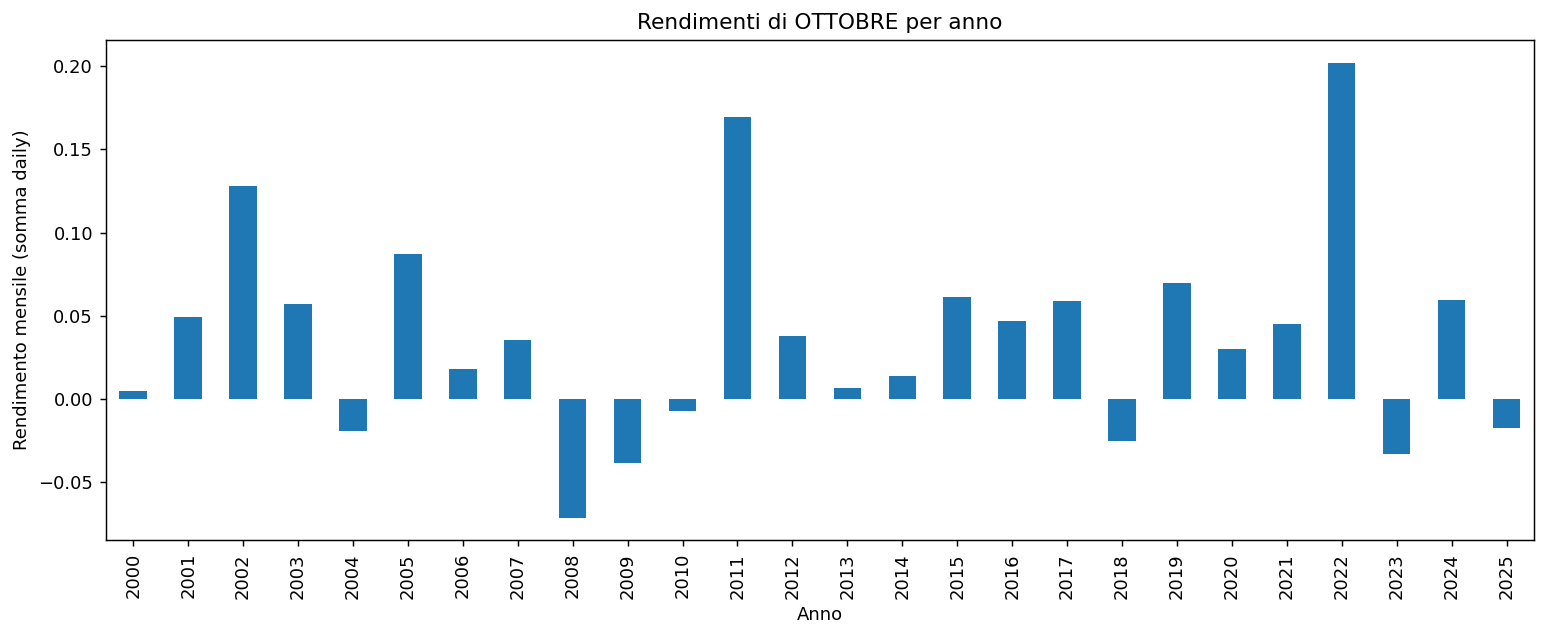

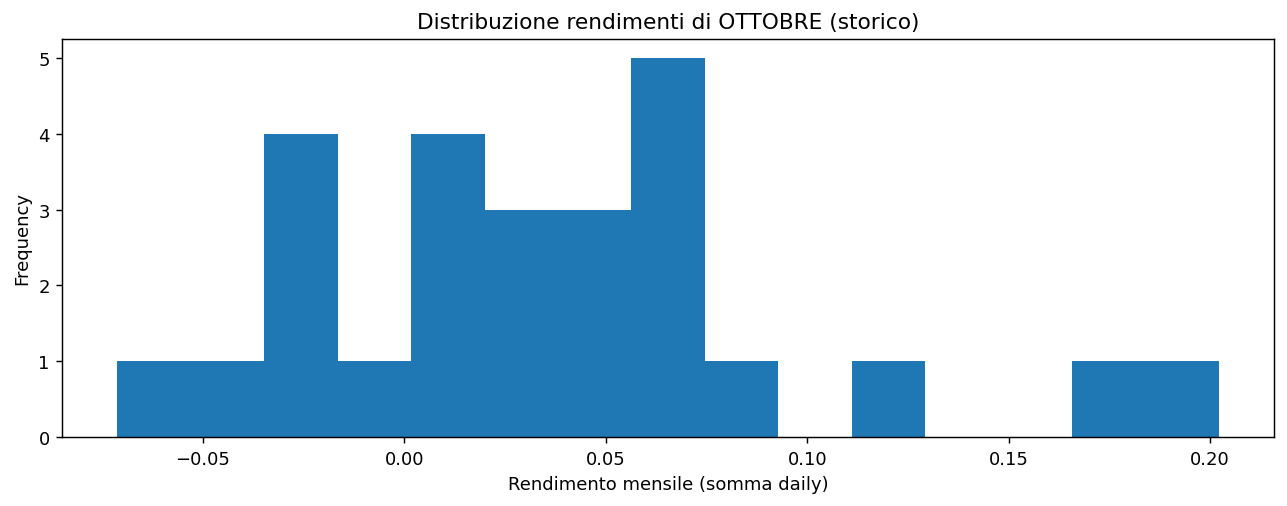


=== OLS: Y (annuo) ~ const + Ottobre ===
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     3.947
Date:                Sun, 05 Oct 2025   Prob (F-statistic):             0.0585
Time:                        07:58:14   Log-Likelihood:                 6.3407
No. Observations:                  26   AIC:                            -8.681
Df Residuals:                      24   BIC:                            -6.165
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

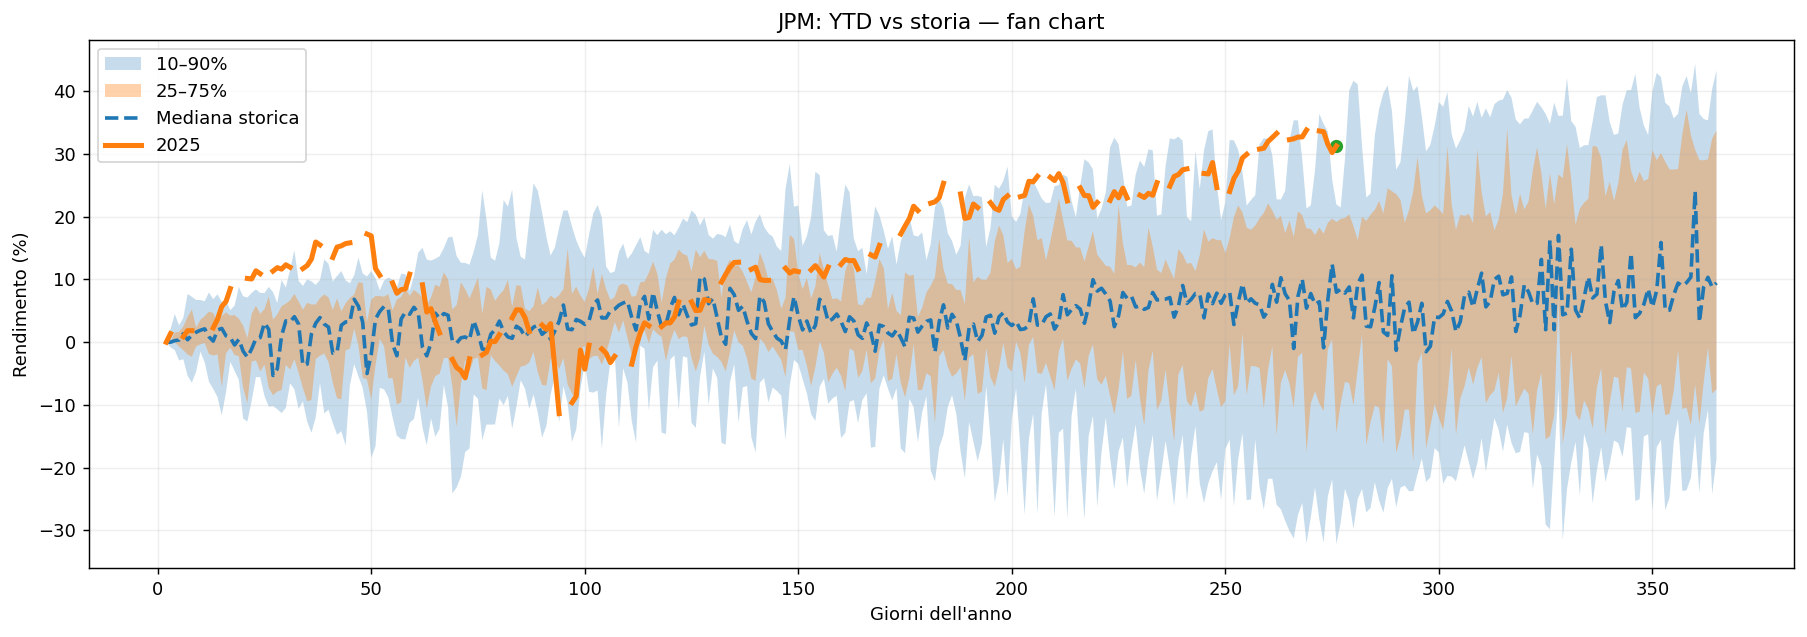

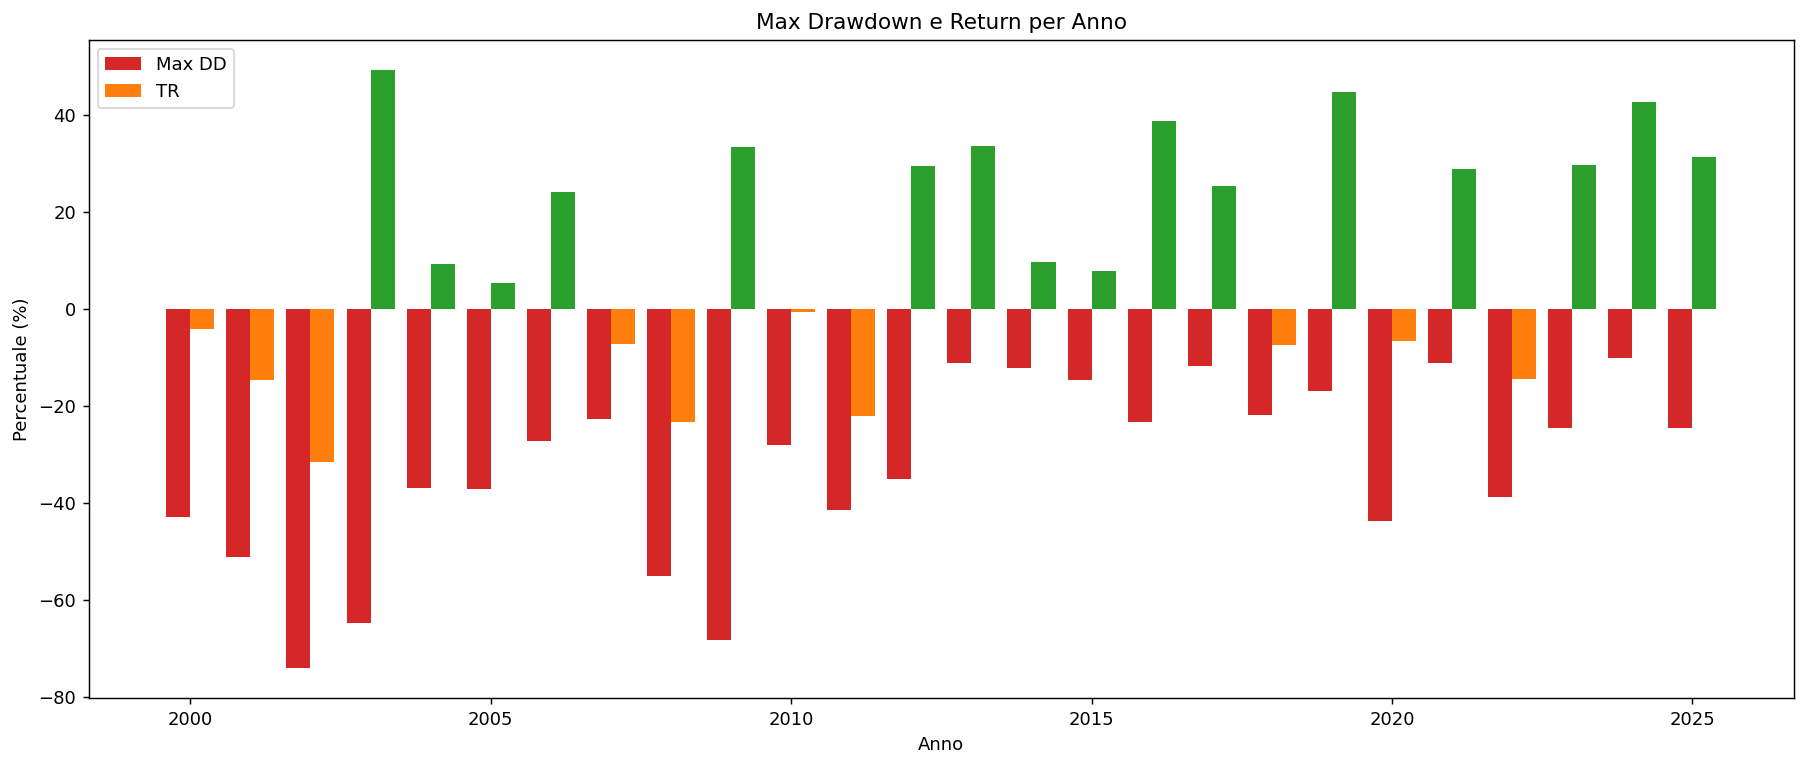

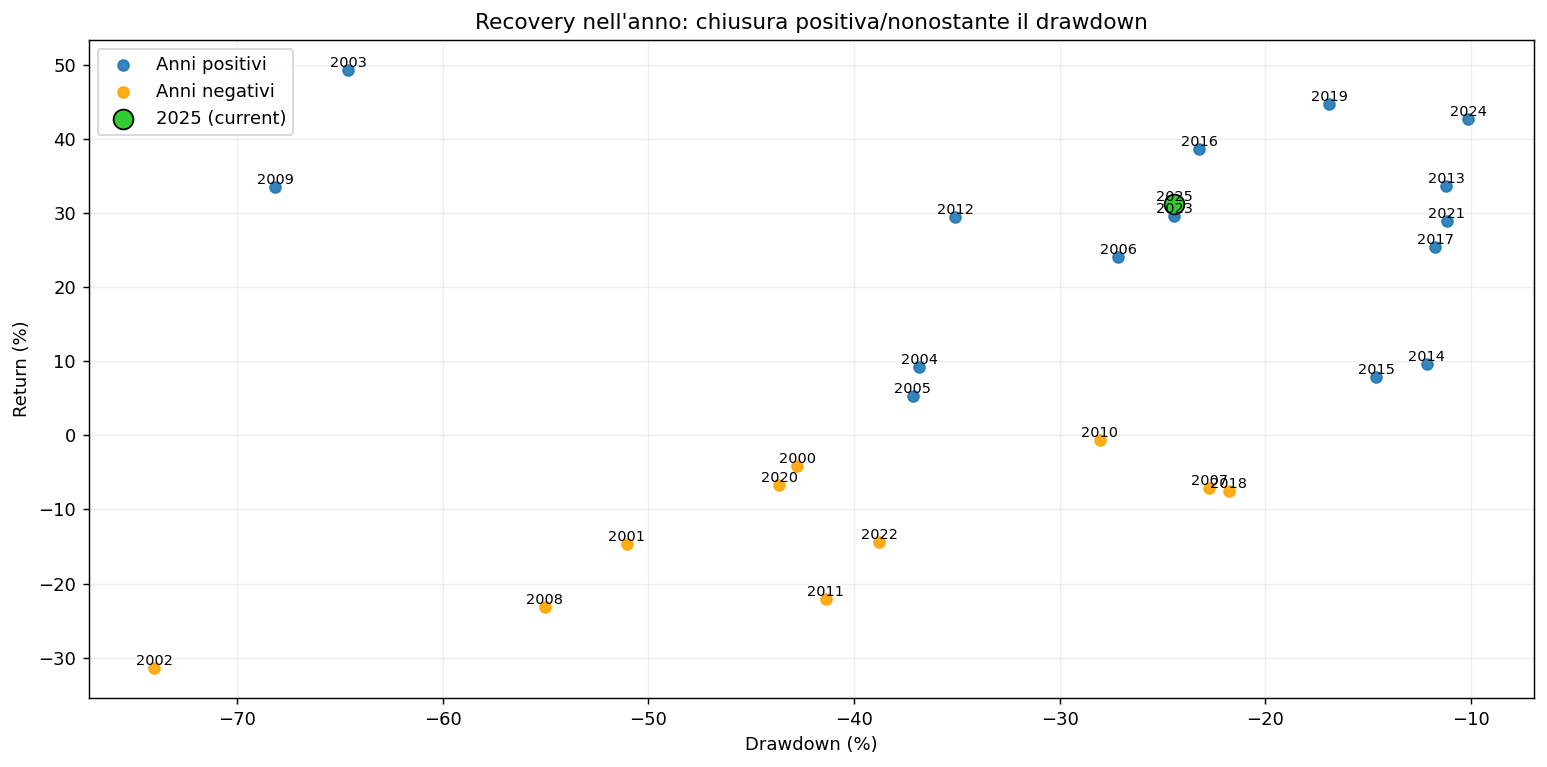


=== Probabilità di chiudere positivo dato MaxDD superato ===
 DD_threshold (%)  anni  positivi  Prob(TR>0 | MaxDD<=thr) %
              -40     8         2                  25.000000
              -35    12         5                  41.666667
              -30    12         5                  41.666667
              -25    14         6                  42.857143
              -20    19         9                  47.368421
              -15    20        10                  50.000000
              -10    26        16                  61.538462
               -5    26        16                  61.538462
                0    26        16                  61.538462


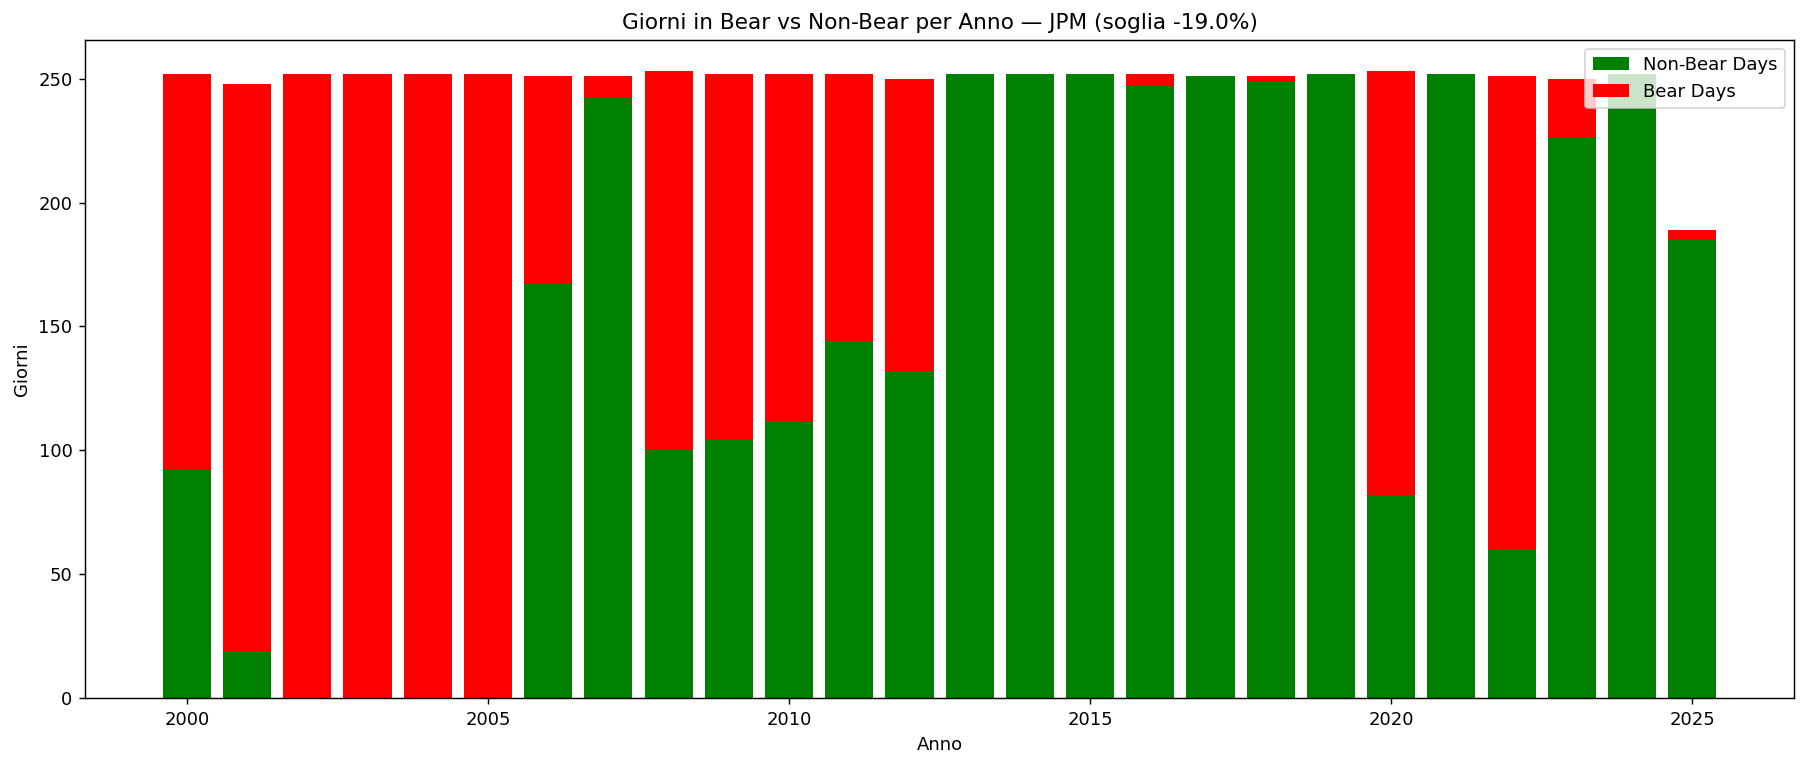


=== Giorni sotto la soglia del 19% per anno ===
      BearDays  TotalDays
Date                     
2000       160        252
2001       229        248
2002       252        252
2003       252        252
2004       252        252
2005       252        252
2006        84        251
2007         9        251
2008       153        253
2009       148        252
2010       140        252
2011       108        252
2012       118        250
2013         0        252
2014         0        252
2015         0        252
2016         5        252
2017         0        251
2018         2        251
2019         0        252
2020       171        253
2021         0        252
2022       191        251
2023        24        250
2024         0        252
2025         4        189

Somiglianza 2025 (gen–set) — metodo: spearman
 2023: 0.825
 2009: 0.724
 2003: 0.704
 2024: 0.689
 2016: 0.657
 2013: 0.644
 2017: 0.632
 2019: 0.545
 2006: 0.535
 2015: 0.417


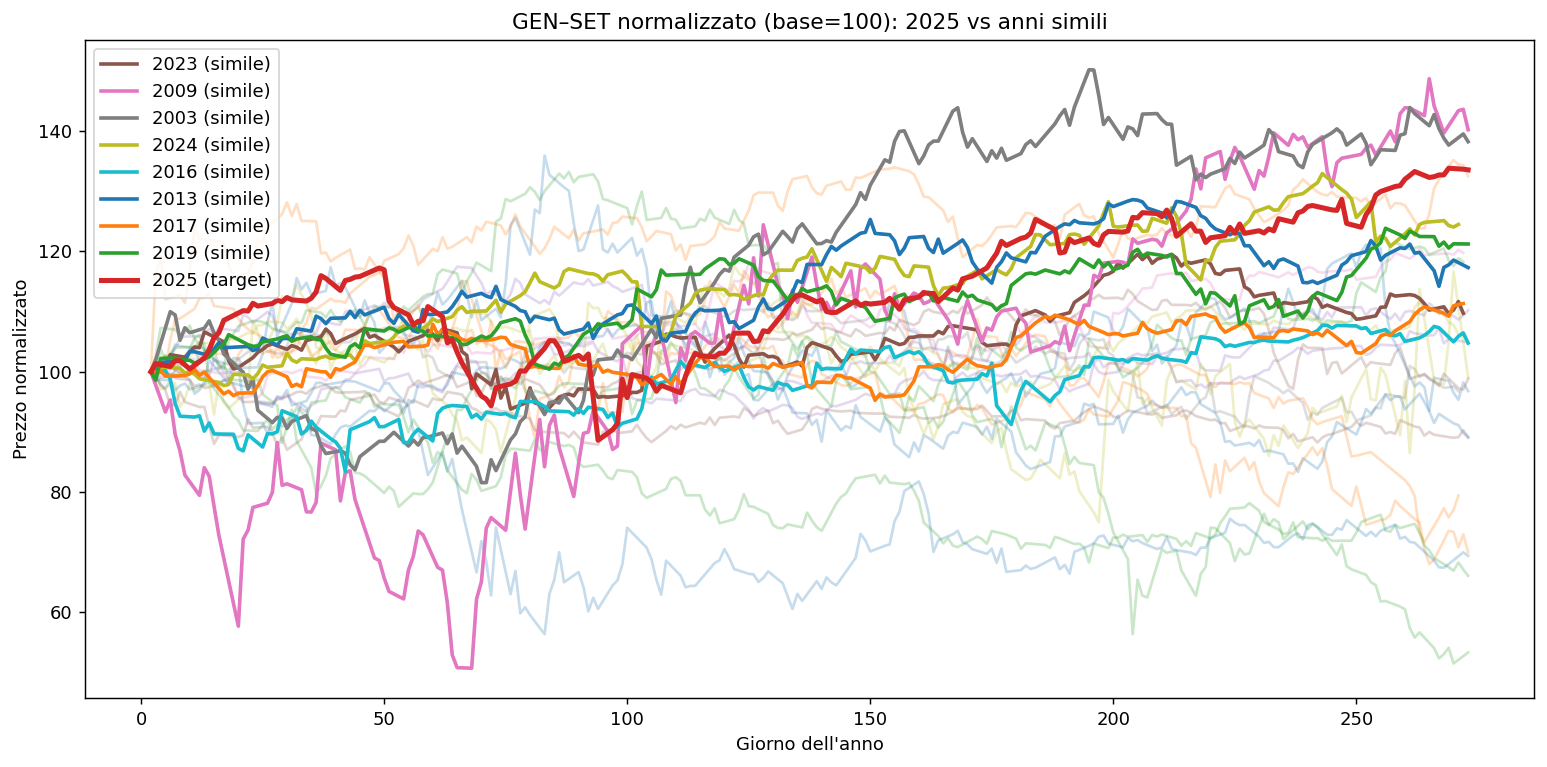

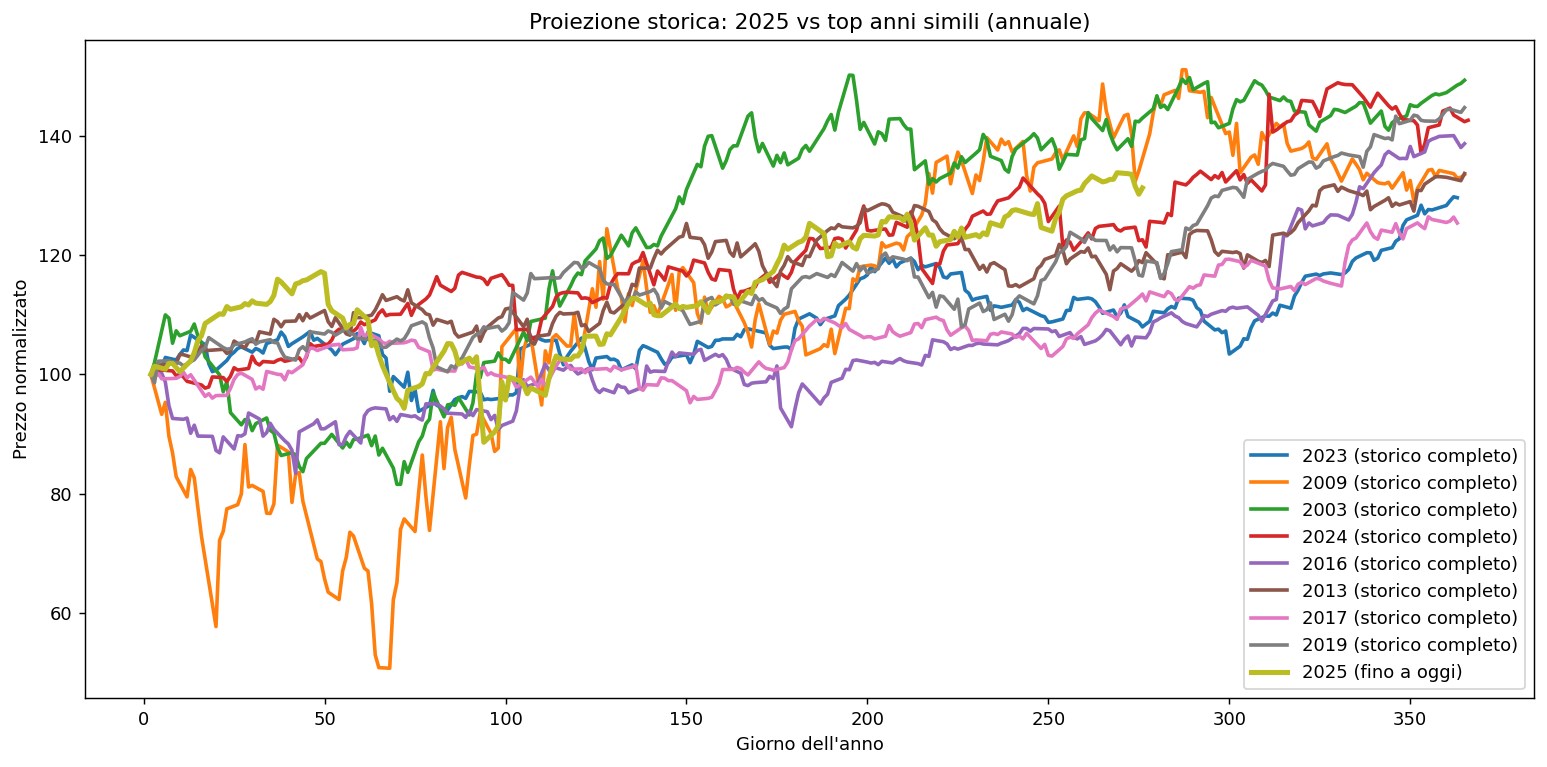


Rendimenti Oct–Dec nei top anni simili:
 year  Oct–Dec %
 2016  30.525961
 2019  21.606823
 2023  19.186976
 2024  14.378715
 2013  13.377279
 2017  11.075098
 2003   4.823087
 2009   0.847091


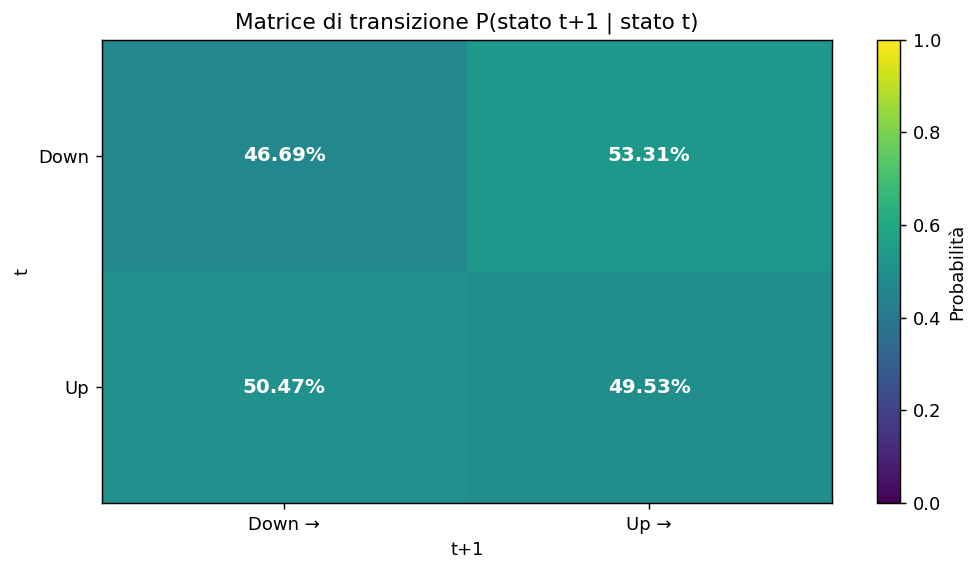


Conteggi:
      Down    Up
Down  1424  1626
Up    1625  1595

Probabilità:
        Down      Up
Down  0.4669  0.5331
Up    0.5047  0.4953


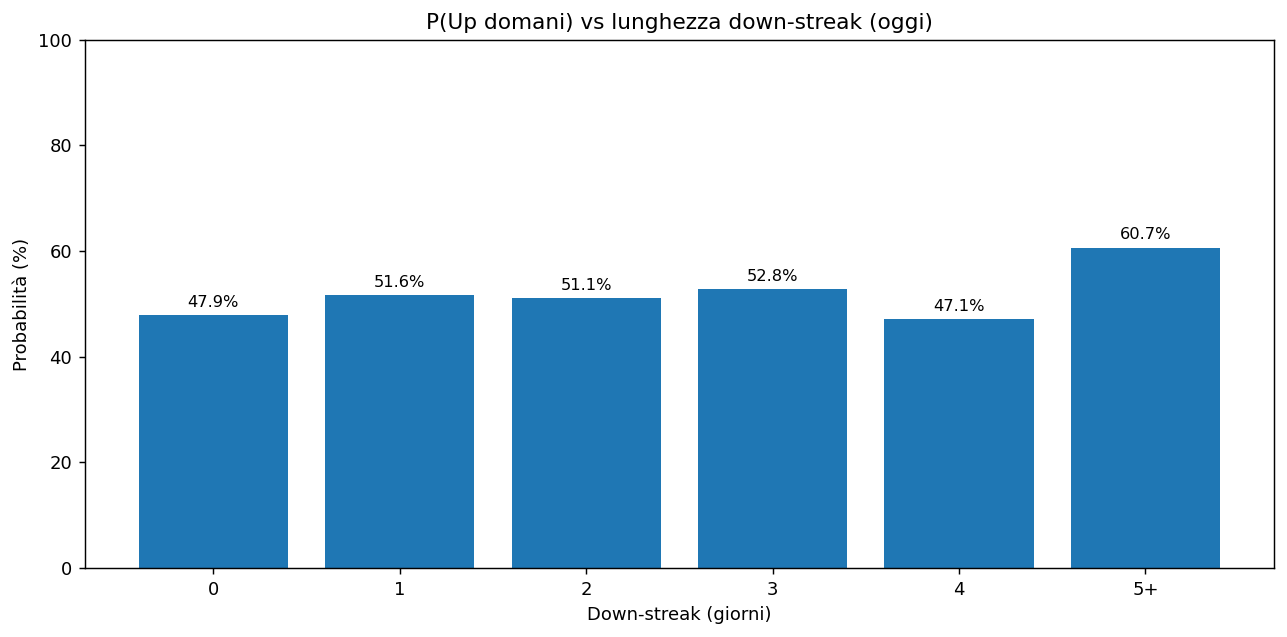

     count  up_next  prob_up (%)
bin                             
0     3427     1642    47.913627
1     1669      862    51.647693
2      763      390    51.114024
3      339      179    52.802360
4      157       74    47.133758
5+     122       74    60.655738


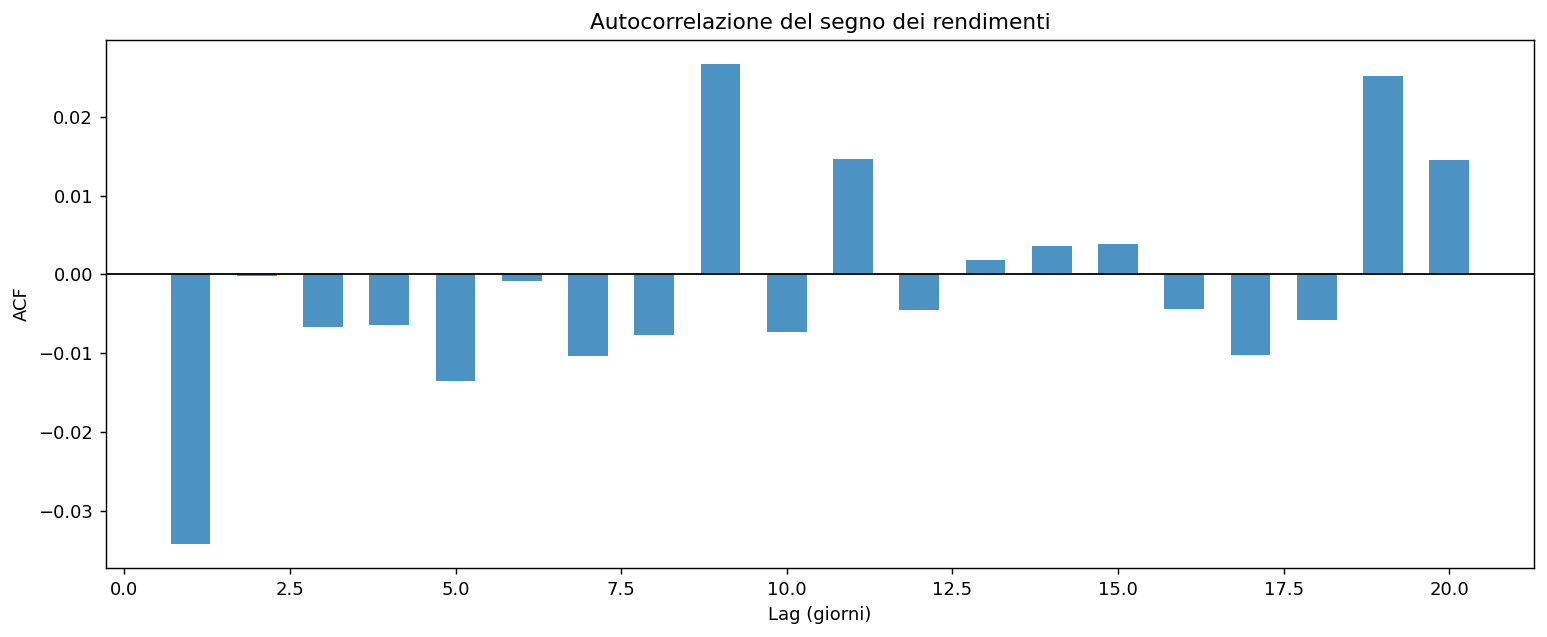

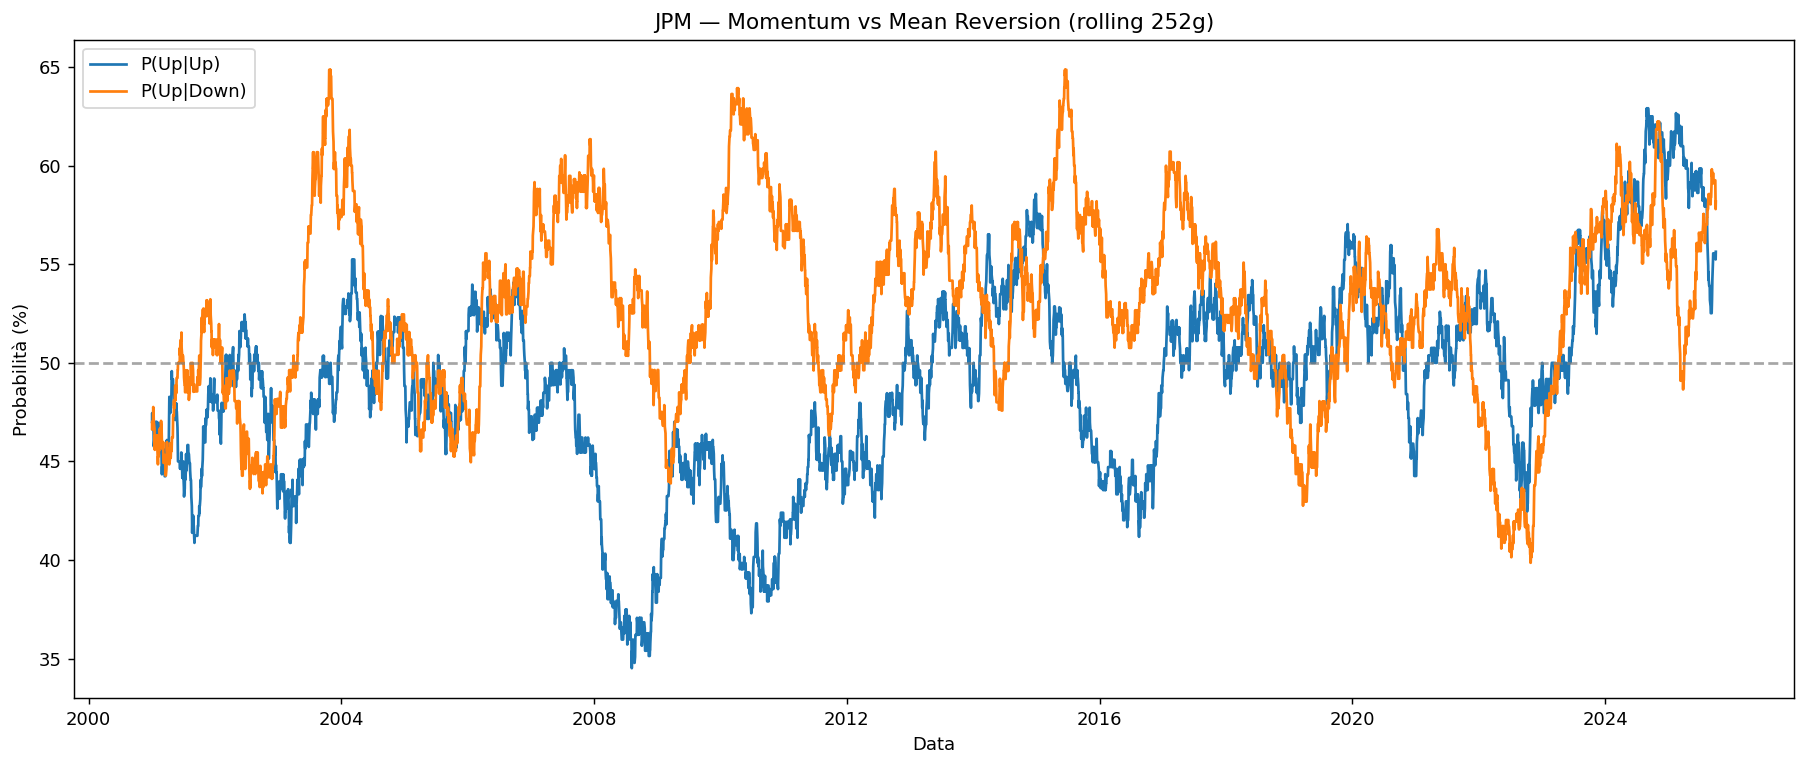

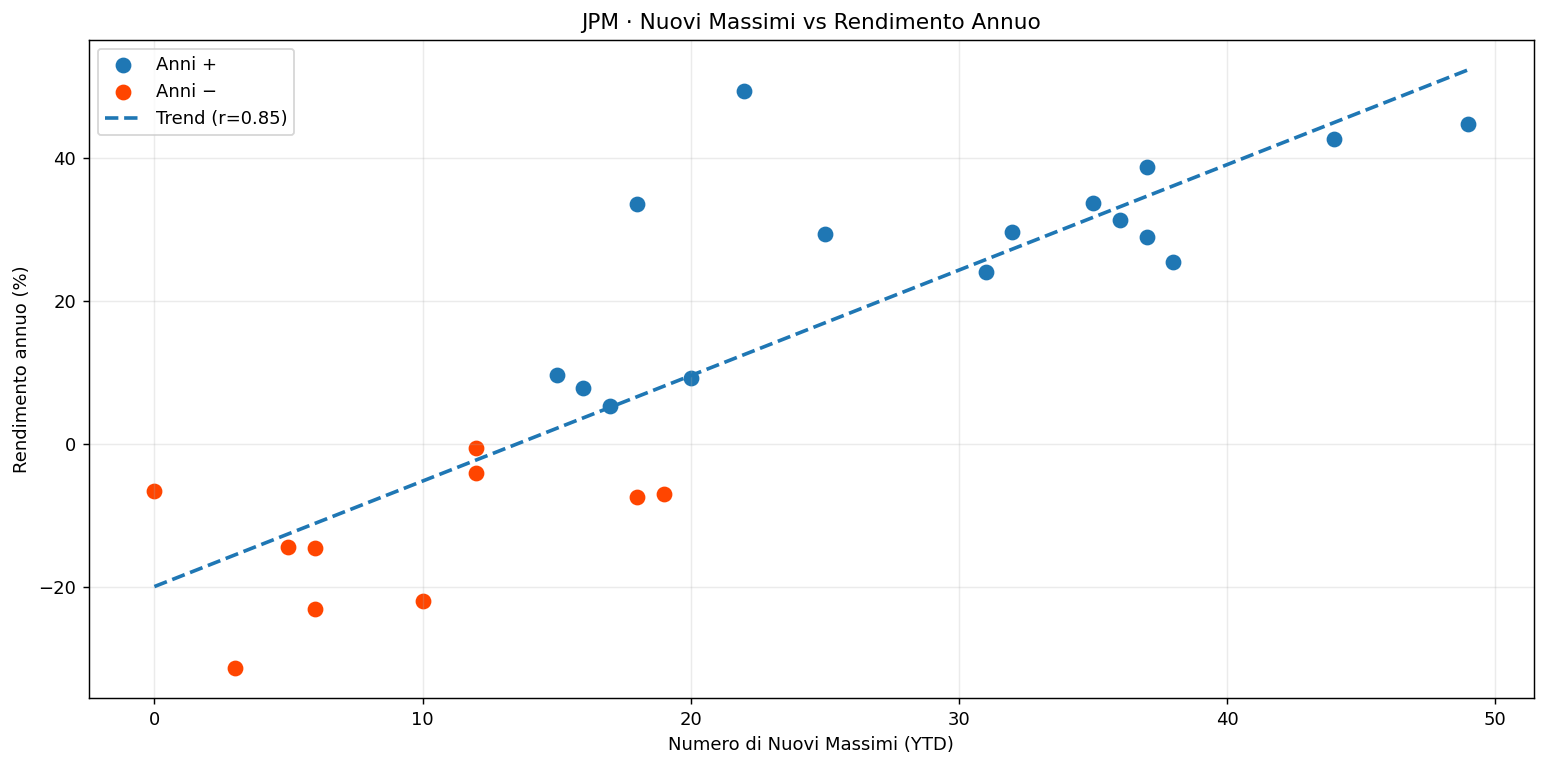


=== Nuovi massimi YTD — riepilogo ===
Media anni positivi: 29.5
Media anni negativi: 9.1


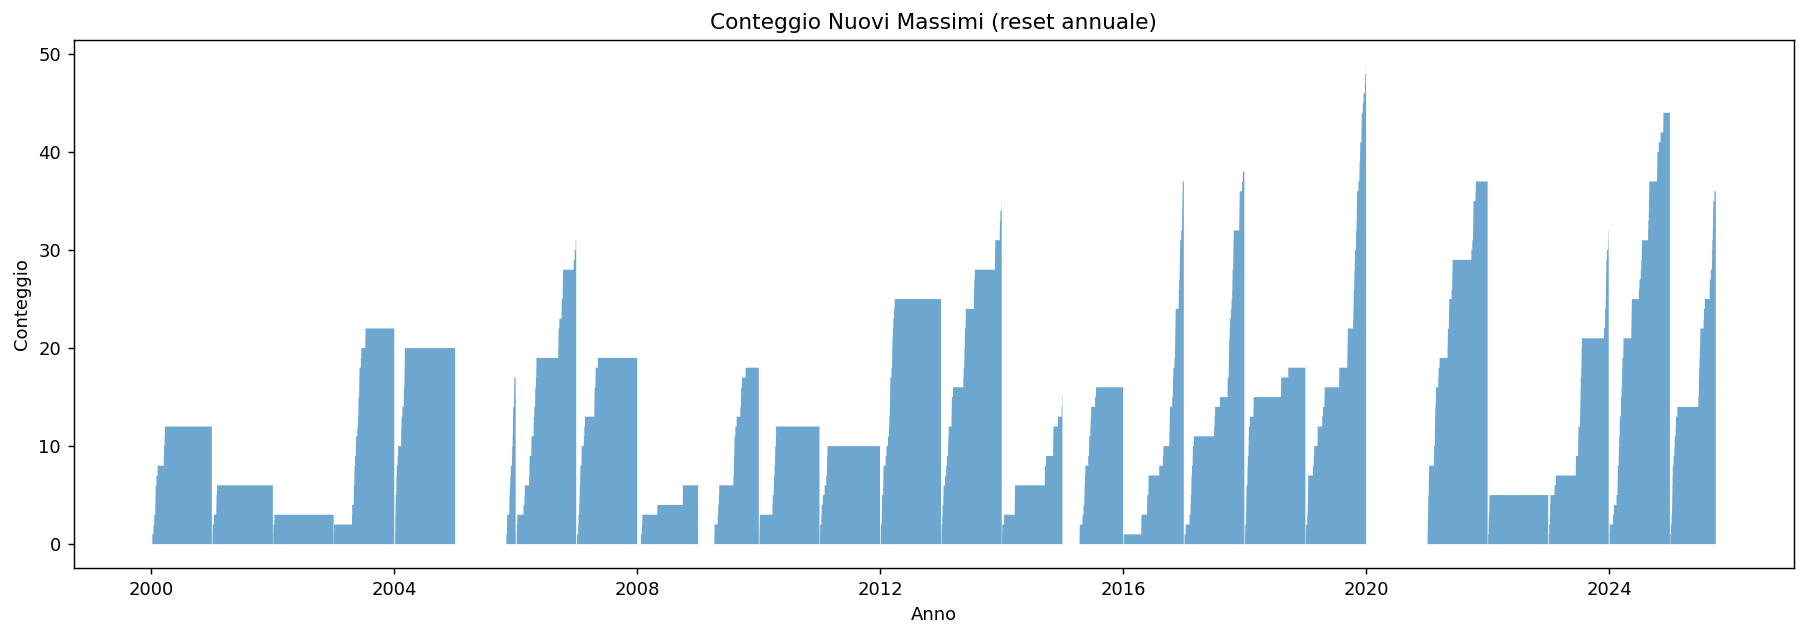


Totale Nuovi Massimi per anno:
Date
2000    12
2001     6
2002     3
2003    22
2004    20
2005    17
2006    31
2007    19
2008     6
2009    18
2010    12
2011    10
2012    25
2013    35
2014    15
2015    16
2016    37
2017    38
2018    18
2019    49
2020     0
2021    37
2022     5
2023    32
2024    44
2025    36


In [5]:
with PdfPages(f"{safe_title(SYMBOL)}_outputs.pdf") as pdf:

    data = yf.download(SYMBOL, start=START_DATE, end=END_DATE, progress=False, auto_adjust=True)
    if data.empty:
        raise ValueError(f"Nessun dato per {SYMBOL}.")
    stock = coerce_to_series(data).sort_index()

    print(f"{SYMBOL} — obs: {len(stock)} | {stock.index.min().date()} → {stock.index.max().date()}")
    last_year = int(stock.index.year.max())

    r_daily = stock.pct_change()
    monthly_returns = r_daily.groupby([r_daily.index.year, r_daily.index.month]).mean()
    monthly_returns.index = monthly_returns.index.set_names(["Year", "Month"])
    monthly_df = monthly_returns.reset_index().dropna()
    monthly_df.columns = ["Year", "Month", "Monthly_Return"]
    monthly_df["Monthly_Return"] = monthly_df["Monthly_Return"].astype(float).clip(-0.5, 0.5)

    ax = monthly_df.boxplot(column="Monthly_Return", by="Month", figsize=(12, 6))
    ax.set_xlabel("Mese"); ax.set_ylabel("Rend. medio giornaliero")
    ax.set_title("Distribuzione rendimenti mensili"); plt.suptitle("")
    ax.set_xticklabels(['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'])
    plt.tight_layout(); pdf.savefig(); plt.show()

    adf_res = adfuller(stock)
    print(f"\n=== ADF su prezzi ({SYMBOL}) ===")
    print(f"ADF: {adf_res[0]:.6f} | p-value: {adf_res[1]:.6f}")
    for k, v in adf_res[4].items():
        print(f" {k}: {v:.3f}")

    log_price = np.log(stock).dropna()
    log_price_c = log_price.asfreq("B").ffill()

    stl = STL(log_price_c, period=252, seasonal=101, robust=True).fit()

    log_ret = log_price.diff().dropna()
    decomp_ret = seasonal_decompose(log_ret.asfreq("B").ffill(), model="additive", period=252)
    resid_ret = decomp_ret.resid.dropna()

    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(311); ax1.plot(stl.observed); ax1.set_title("Observed (log-price)")
    ax2 = fig.add_subplot(312); ax2.plot(stl.trend);    ax2.set_title("Trend (STL)")
    ax3 = fig.add_subplot(313); ax3.plot(resid_ret);    ax3.set_title("Resid (log-return)")
    plt.tight_layout(); pdf.savefig(fig); plt.show()

    def plot_seasonality_adjusted(year: int):
        s_year = coerce_to_series(stock.loc[stock.index.year == year])
        seas_year = coerce_to_series(stl.seasonal.loc[stl.seasonal.index.year == year])
        df = pd.concat([s_year.rename("price"), seas_year.rename("seasonal")], axis=1, join="inner").dropna()
        if df.empty:
            print(f"Niente dati per {year}"); return
        df["de_seasonal"] = np.exp(np.log(df["price"]) - df["seasonal"])
        fig, ax = plt.subplots(figsize=(12,5))
        ax.plot(df.index, df["price"], label="Prezzo")
        ax.plot(df.index, df["de_seasonal"], label="Destagionalizzato")
        ax.set_title(f"{SYMBOL} — {year}")
        ax.grid(True, alpha=0.2); ax.legend(); plt.tight_layout(); pdf.savefig(fig); plt.show()

    plot_seasonality_adjusted(last_year)

    r = stock.pct_change().replace([np.inf, -np.inf], np.nan).dropna()
    monthly_sum = r.resample("ME").sum()
    monthly_df2 = monthly_sum.to_frame("Monthly_Return") if isinstance(monthly_sum, pd.Series) \
                   else monthly_sum.iloc[:, [0]].rename(columns={monthly_sum.columns[0]:"Monthly_Return"})
    monthly_df2["Year"] = monthly_df2.index.year
    monthly_df2["Month"] = monthly_df2.index.month

    october = (monthly_df2[monthly_df2["Month"]==10].set_index("Year")["Monthly_Return"].sort_index())
    if len(october)==0:
        print(" Ottobre: dati insufficienti.")
    else:
        october = october.astype(float); october.name="Oct_Return"
        yearly = coerce_to_series(r.resample("YE").sum()); yearly.index = yearly.index.year; yearly.name="Y"

        print("\n=== Ottobre: statistiche ===")
        print(october.describe())
        print(f"Hit rate (ottobre>0): {(october>0).mean():.1%}")

        wide = monthly_df2.pivot_table(index="Year", columns="Month", values="Monthly_Return")
        if 10 in wide.columns:
            others_mean = wide.drop(columns=[10]).mean(axis=1, skipna=True)
            common = october.index.intersection(others_mean.index)
            if len(common)>0:
                print(f"Δ medio (Ott - media altri mesi): {(october.loc[common]-others_mean.loc[common]).mean():.4f}")

        october.plot(kind="bar", figsize=(12,5), title="Rendimenti di OTTOBRE per anno")
        plt.xlabel("Anno"); plt.ylabel("Rendimento mensile (somma daily)")
        plt.tight_layout(); pdf.savefig(); plt.show()

        october.plot(kind="hist", bins=15, figsize=(10,4), title="Distribuzione rendimenti di OTTOBRE (storico)")
        plt.xlabel("Rendimento mensile (somma daily)")
        plt.tight_layout(); pdf.savefig(); plt.show()

        idx = yearly.index.intersection(october.index)
        if len(idx)>=5:
            y = yearly.loc[idx].astype(float)
            X = sm.add_constant(october.loc[idx].to_frame("Oct"), has_constant="add")
            model_oct = sm.OLS(y, X, missing="drop").fit()
            print("\n=== OLS: Y (annuo) ~ const + Ottobre ===")
            print(model_oct.summary())

    def assess_current_price_action(stock_like: pd.Series, current_year: int = None):
        s = coerce_to_series(stock_like).sort_index()
        if s.empty: raise ValueError("Serie vuota.")
        if current_year is None:
            current_year = int(s.index.year.max())

        year_map = {}
        for y in sorted(s.index.year.unique()):
            sy = s[s.index.year == y]
            if sy.empty: continue
            base = float(sy.iloc[0])
            if not np.isfinite(base) or base==0: continue
            perf = (sy/base - 1.0)*100.0
            perf.index = perf.index.dayofyear
            perf = perf[perf.index<=365]
            year_map[y] = perf.astype(float)

        all_years = sorted(year_map.keys())
        doy = pd.Index(range(1,366), name="DOY")
        df = pd.DataFrame(index=doy, columns=all_years, dtype=float)
        for y, ser in year_map.items():
            df[y] = ser.reindex(doy)

        hist_years = [y for y in all_years if y!=current_year] or all_years
        hist = df[hist_years]
        p10 = hist.quantile(0.10, axis=1); p25 = hist.quantile(0.25, axis=1)
        p50 = hist.quantile(0.50, axis=1); p75 = hist.quantile(0.75, axis=1)
        p90 = hist.quantile(0.90, axis=1)
        current_curve = df[current_year]

        fig, ax = plt.subplots(figsize=(14,5))
        ax.fill_between(doy, p10, p90, alpha=0.25, label="10–90%")
        ax.fill_between(doy, p25, p75, alpha=0.35, label="25–75%")
        ax.plot(doy, p50, linestyle="--", linewidth=2.0, label="Mediana storica")
        ax.plot(doy, current_curve, linewidth=2.8, label=f"{current_year}")
        valid = current_curve.dropna()
        if not valid.empty:
            ax.scatter([int(valid.index.max())], [float(valid.iloc[-1])], s=40)
        ax.set_title(f"{SYMBOL}: YTD vs storia — fan chart")
        ax.set_xlabel("Giorni dell'anno"); ax.set_ylabel("Rendimento (%)")
        ax.grid(True, alpha=0.2); ax.legend(loc="upper left")
        plt.tight_layout(); pdf.savefig(); plt.show()

    assess_current_price_action(stock, current_year=None)

    def rolling_max_drawdown(series: pd.Series) -> pd.Series:
        s = coerce_to_series(series).astype(float).sort_index()
        return s / s.cummax() - 1.0

    def annual_return(series: pd.Series) -> pd.Series:
        s = coerce_to_series(series).astype(float).sort_index()
        g = s.resample("YE")
        ret = g.last() / g.first() - 1.0
        ret.name = "YearReturn"; return ret

    def annual_max_drawdown(series: pd.Series) -> pd.Series:
        dd = rolling_max_drawdown(series).sort_index()
        out = dd.resample("YE").min(); out.name = "MaxDD"; return out

    tr_year = annual_return(stock)
    dd_year = annual_max_drawdown(stock)
    dd_df = pd.concat([tr_year, dd_year], axis=1).dropna()
    dd_df.index = dd_df.index.year.astype(int)

    fig, ax = plt.subplots(figsize=(14,6))
    ax.bar(dd_df.index-0.2, dd_df["MaxDD"]*100, width=0.4, label="Max DD", color="tab:red")
    colors = ["tab:green" if v>=0 else "tab:orange" for v in dd_df["YearReturn"]]
    ax.bar(dd_df.index+0.2, dd_df["YearReturn"]*100, width=0.4, label="TR", color=colors)
    ax.set_title("Max Drawdown e Return per Anno")
    ax.set_xlabel("Anno"); ax.set_ylabel("Percentuale (%)")
    ax.legend(); plt.tight_layout(); pdf.savefig(); plt.show()

    fig, ax = plt.subplots(figsize=(12,6))
    pos = dd_df["YearReturn"] > 0
    ax.scatter(dd_df.loc[pos, "MaxDD"]*100, dd_df.loc[pos, "YearReturn"]*100, label="Anni positivi", alpha=0.9)
    ax.scatter(dd_df.loc[~pos,"MaxDD"]*100, dd_df.loc[~pos,"YearReturn"]*100, label="Anni negativi", alpha=0.9, color="orange")
    if last_year in dd_df.index:
        ax.scatter(dd_df.loc[last_year,"MaxDD"]*100, dd_df.loc[last_year,"YearReturn"]*100, s=120, edgecolors="k", color="limegreen", label=f"{last_year} (current)")
    for yr, (xv, yv) in dd_df[["MaxDD","YearReturn"]].mul(100).iterrows():
        ax.text(xv, yv, str(yr), fontsize=8, va="bottom", ha="center")
    ax.set_xlabel("Drawdown (%)"); ax.set_ylabel("Return (%)")
    ax.set_title("Recovery nell'anno: chiusura positiva/nonostante il drawdown")
    ax.grid(True, alpha=0.2); ax.legend()
    plt.tight_layout(); pdf.savefig(); plt.show()

    def prob_finish_positive_given_dd(series: pd.Series, dd_levels=(-40,-35,-30,-25,-20,-15,-10,-5,0)):
        tr = annual_return(series); dd = annual_max_drawdown(series)
        df = pd.concat([tr, dd], axis=1).dropna()
        out = []
        for lev in dd_levels:
            m = (df["MaxDD"]*100) <= lev
            n = int(m.sum()); pos_ = int((df.loc[m,"YearReturn"]>0).sum())
            out.append({"DD_threshold (%)": lev, "anni": n, "positivi": pos_, "Prob(TR>0 | MaxDD<=thr) %": (pos_/n*100) if n>0 else np.nan})
        return pd.DataFrame(out)

    tbl = prob_finish_positive_given_dd(stock)
    print("\n=== Probabilità di chiudere positivo dato MaxDD superato ===")
    print(tbl.to_string(index=False))

    BEAR_THRESHOLD = -0.19

    dd_series = rolling_max_drawdown(stock).astype(float)
    is_bear = dd_series <= BEAR_THRESHOLD

    days_per_year = is_bear.groupby(is_bear.index.year).agg(["sum", "count"])
    days_per_year.columns = ["BearDays", "TotalDays"]
    days_per_year["NonBearDays"] = days_per_year["TotalDays"] - days_per_year["BearDays"]

    fig, ax = plt.subplots(figsize=(14, 6))
    years = days_per_year.index.values
    ax.bar(years, days_per_year["NonBearDays"], label="Non-Bear Days", color='green')
    ax.bar(years, days_per_year["BearDays"], bottom=days_per_year["NonBearDays"], label="Bear Days", color='red')
    ax.set_title(f"Giorni in Bear vs Non-Bear per Anno — {SYMBOL} (soglia {BEAR_THRESHOLD*100}%)")
    ax.set_xlabel("Anno"); ax.set_ylabel("Giorni")
    ax.legend()
    plt.tight_layout(); pdf.savefig(); plt.show()

    print("\n=== Giorni sotto la soglia del 19% per anno ===")
    print(days_per_year[["BearDays", "TotalDays"]].to_string())

    def year_similarity_projection(price_like, target_year:int, top_n:int=3, method:str="pearson", min_overlap_days:int=30):
        SEP_30_DOY = 273
        s = coerce_to_series(price_like).sort_index()
        if s.empty: return

        year_map = {}
        for y in sorted(s.index.year.unique()):
            sy = s[s.index.year==y].dropna()
            if len(sy)<min_overlap_days: continue
            base = float(sy.iloc[0])
            if not np.isfinite(base) or base==0: continue
            doys = (sy/base*100.0); doys.index = doys.index.dayofyear
            year_map[y] = doys.astype(float)

        if target_year not in year_map or year_map[target_year].empty:
            print(f"Nessun dato per target_year={target_year}."); return

        target = year_map[target_year].loc[year_map[target_year].index<=SEP_30_DOY].dropna()

        corrs=[]
        for y, s_y in year_map.items():
            if y==target_year: continue
            comp = s_y.loc[s_y.index<=SEP_30_DOY].dropna()
            idx = target.index.intersection(comp.index)
            if idx.size>=min_overlap_days:
                c = target.loc[idx].corr(comp.loc[idx], method=method)
                if pd.notna(c): corrs.append((y,float(c)))
        if not corrs:
            print("Nessun anno comparabile."); return
        corrs = sorted(corrs, key=lambda x:x[1], reverse=True)
        top_years = [y for y,_ in corrs[:max(1,int(top_n))]]

        print(f"\nSomiglianza {target_year} (gen–set) — metodo: {method}")
        for y,c in corrs[:max(10, top_n)]:
            print(f" {y}: {c:.3f}")

        plt.figure(figsize=(12,6))
        for y, s_y in year_map.items():
            if y==target_year: continue
            js = s_y.loc[s_y.index<=SEP_30_DOY]
            if not js.empty: plt.plot(js.index.values, js.values, alpha=0.25)
        for y in top_years:
            js = year_map[y].loc[year_map[y].index<=SEP_30_DOY]
            if not js.empty: plt.plot(js.index.values, js.values, linewidth=2.0, label=f"{y} (simile)")
        plt.plot(target.index.values, target.values, linewidth=2.8, label=f"{target_year} (target)")
        plt.title(f"GEN–SET normalizzato (base=100): {target_year} vs anni simili")
        plt.xlabel("Giorno dell'anno"); plt.ylabel("Prezzo normalizzato")
        plt.legend(); plt.tight_layout(); pdf.savefig(); plt.show()

        plt.figure(figsize=(12,6))
        for y in top_years:
            whole = year_map[y]
            if not whole.empty: plt.plot(whole.index.values, whole.values, linewidth=2.0, label=f"{y} (storico completo)")
        plt.plot(year_map[target_year].index.values, year_map[target_year].values, linewidth=2.8, label=f"{target_year} (fino a oggi)")
        plt.title(f"Proiezione storica: {target_year} vs top anni simili (annuale)")
        plt.xlabel("Giorno dell'anno"); plt.ylabel("Prezzo normalizzato")
        plt.legend(); plt.tight_layout(); pdf.savefig(); plt.show()

        def oct_dec_return(series_doy: pd.Series) -> float:
            tail = series_doy.loc[series_doy.index>SEP_30_DOY].dropna()
            if tail.shape[0]<2: return np.nan
            start, end = float(tail.iloc[0]), float(tail.iloc[-1])
            return np.nan if (np.isnan(start) or start==0.0) else (end-start)/start*100.0

        rows = [{"year":int(y), "Oct–Dec %": oct_dec_return(year_map[y])} for y in top_years]
        df_proj = pd.DataFrame(rows).dropna(subset=["Oct–Dec %"])
        if not df_proj.empty:
            print("\nRendimenti Oct–Dec nei top anni simili:")
            print(df_proj.sort_values("Oct–Dec %", ascending=False).to_string(index=False))

    year_similarity_projection(stock, target_year=last_year, top_n=TOP_N_YEARS, method=CORR_METHOD)

    def transition_matrix_updown(prices: pd.Series, threshold=0.0, drop_flats=True,
                                 title="Matrice di transizione P(stato t+1 | stato t)"):
        s = coerce_to_series(prices).sort_index()
        r = s.pct_change().dropna()
        state = pd.Series(index=r.index, dtype="object")
        up = r > +threshold; down = r < -threshold; flat = ~(up | down)
        state[up] = "Up"; state[down] = "Down"
        if flat.any():
            state = state[~flat] if drop_flats else state.ffill().fillna("Down")
        if len(state)<5: raise ValueError("Serie di stati troppo corta.")
        st, st1 = state.iloc[:-1].values, state.iloc[1:].values
        cats = ["Down","Up"]
        C = pd.DataFrame(0, index=cats, columns=cats, dtype=int)
        for a,b in zip(st, st1):
            if a in cats and b in cats: C.loc[a,b]+=1
        P = C.div(C.sum(axis=1).replace(0,np.nan), axis=0)

        fig, ax = plt.subplots(figsize=(8,4.5))
        im = ax.imshow(P.values, cmap="viridis", vmin=0, vmax=1, aspect="auto")
        ax.set_xticks(range(2)); ax.set_yticks(range(2))
        ax.set_xticklabels([f"{c} →" for c in cats]); ax.set_yticklabels(cats)
        ax.set_xlabel("t+1"); ax.set_ylabel("t"); ax.set_title(title)
        for i in range(2):
            for j in range(2):
                val = P.iloc[i,j]; txt = "--" if pd.isna(val) else f"{val*100:,.2f}%"
                ax.text(j, i, txt, va="center", ha="center", color="white", fontsize=11, fontweight="bold")
        plt.colorbar(im, ax=ax).set_label("Probabilità")
        plt.tight_layout(); pdf.savefig(); plt.show()

        print("\nConteggi:")
        print(C.to_string())
        print("\nProbabilità:")
        print(P.round(4).to_string())
        return P, C

    _ = transition_matrix_updown(stock, threshold=OCT_THRESHOLD, drop_flats=True)

    def prob_up_after_downstreak(prices: pd.Series, threshold=0.0, max_bin=5):
        s = coerce_to_series(prices).sort_index()
        r = s.pct_change()
        up = r > +threshold
        down = r < -threshold
        streak = pd.Series(0, index=r.index, dtype=int)
        c = 0
        for i, is_down in enumerate(down.fillna(False).values):
            c = c+1 if is_down else 0
            streak.iat[i] = c
        df = pd.DataFrame({"streak": streak, "up_next": up.shift(-1)}).dropna()
        labels = [str(k) for k in range(max_bin)] + [f"{max_bin}+"]
        def bin_streak(x):
            x=int(x)
            return str(x) if x<max_bin else f"{max_bin}+"
        df["bin"] = df["streak"].map(bin_streak)
        counts = df.groupby("bin")["up_next"].count().reindex(labels, fill_value=0)
        up_next = df.groupby("bin")["up_next"].sum().reindex(labels, fill_value=0)
        prob_up = (up_next / counts.replace(0,np.nan) * 100.0)
        out = pd.DataFrame({"count": counts.astype(int), "up_next": up_next.astype(int), "prob_up (%)": prob_up})

        plt.figure(figsize=(10,5))
        plt.bar(out.index, out["prob_up (%)"])
        plt.ylim(0,100); plt.title("P(Up domani) vs lunghezza down-streak (oggi)")
        plt.xlabel("Down-streak (giorni)"); plt.ylabel("Probabilità (%)")
        for x_, y_ in zip(out.index, out["prob_up (%)"]):
            if pd.notna(y_): plt.text(x_, y_+1, f"{y_:.1f}%", ha="center", va="bottom", fontsize=9)
        plt.tight_layout(); pdf.savefig(); plt.show()

        print(out.fillna(0).to_string())
        return out

    _ = prob_up_after_downstreak(stock, threshold=OCT_THRESHOLD, max_bin=5)

    def plot_sign_autocorr(stock_series: pd.Series, lags=20):
        r = coerce_to_series(stock_series).pct_change().dropna()
        sign_r = np.sign(r)
        acf_vals = acf(sign_r, nlags=lags, fft=True)
        plt.figure(figsize=(12,5))
        plt.bar(range(1, lags+1), acf_vals[1:], width=0.6, alpha=0.8)
        plt.axhline(0, color="black", linewidth=1)
        plt.title("Autocorrelazione del segno dei rendimenti")
        plt.xlabel("Lag (giorni)"); plt.ylabel("ACF")
        plt.tight_layout(); pdf.savefig(); plt.show()
        return acf_vals

    _ = plot_sign_autocorr(stock, lags=ACF_LAGS)

    def conditional_hit_rate(stock_series: pd.Series, window=252):
        s = coerce_to_series(stock_series).dropna()
        r = s.pct_change().dropna()
        sign = np.where(r>0, 1, -1)
        df = pd.DataFrame({"sign": sign[:-1], "next": sign[1:]}, index=r.index[:-1])
        df["up_cond"] = df["sign"]==1
        df["down_cond"] = df["sign"]==-1
        df["is_up_next"] = df["next"]==1
        p_up_up = (df["is_up_next"] & df["up_cond"]).rolling(window).sum() / df["up_cond"].rolling(window).sum()
        p_up_down = (df["is_up_next"] & df["down_cond"]).rolling(window).sum() / df["down_cond"].rolling(window).sum()
        return p_up_up, p_up_down

    p_up_up, p_up_down = conditional_hit_rate(stock, window=ROLL_WIN)
    plt.figure(figsize=(14,6))
    plt.plot((p_up_up*100).index, p_up_up*100, label="P(Up|Up)")
    plt.plot((p_up_down*100).index, p_up_down*100, label="P(Up|Down)")
    plt.axhline(50, linestyle="--", color="gray", alpha=0.7)
    plt.title(f"{SYMBOL} — Momentum vs Mean Reversion (rolling {ROLL_WIN}g)")
    plt.ylabel("Probabilità (%)"); plt.xlabel("Data")
    plt.legend(); plt.tight_layout(); pdf.savefig(); plt.show()

    def count_ytd_new_highs(s: pd.Series) -> pd.DataFrame:
        s = coerce_to_series(s).astype(float).sort_index()
        years = sorted(s.index.year.unique())
        rows = []
        for y in years:
            sy = s[s.index.year == y]
            if sy.empty:
                continue
            running_max = sy.cummax().shift(1).fillna(sy.iloc[0])
            is_new_high = sy > running_max
            n_highs = int(is_new_high.sum())
            ret = float(sy.iloc[-1] / sy.iloc[0] - 1.0)
            rows.append({"Year": int(y), "NewHighs": n_highs, "YearReturn": ret})
        return pd.DataFrame(rows).set_index("Year")

    nh_df = count_ytd_new_highs(stock)

    fig, ax = plt.subplots(figsize=(12,6))
    pos = nh_df["YearReturn"] > 0
    ax.scatter(nh_df.loc[pos, "NewHighs"],  nh_df.loc[pos, "YearReturn"]*100, label="Anni +", s=60)
    ax.scatter(nh_df.loc[~pos,"NewHighs"], nh_df.loc[~pos,"YearReturn"]*100, label="Anni −", s=60, color="orangered")

    x = nh_df["NewHighs"].astype(float).values
    y = (nh_df["YearReturn"]*100.0).astype(float).values
    if len(nh_df) >= 3 and np.nanstd(x) > 0:
        slope, intercept, r_val, p, _ = stats.linregress(x, y)
        xfit = np.linspace(np.nanmin(x), np.nanmax(x), 100)
        yfit = intercept + slope*xfit
        ax.plot(xfit, yfit, linestyle="--", linewidth=2, label=f"Trend (r={r_val:.2f})")

    ax.set_xlabel("Numero di Nuovi Massimi (YTD)")
    ax.set_ylabel("Rendimento annuo (%)")
    ax.set_title(f"{SYMBOL} · Nuovi Massimi vs Rendimento Annuo")
    ax.grid(True, alpha=0.25); ax.legend()
    plt.tight_layout(); pdf.savefig(); plt.show()

    print("\n=== Nuovi massimi YTD — riepilogo ===")
    print("Media anni positivi:", nh_df.loc[pos,"NewHighs"].mean().round(2) if pos.any() else "n/d")
    print("Media anni negativi:", nh_df.loc[~pos,"NewHighs"].mean().round(2) if (~pos).any() else "n/d")

    def ytd_new_high_counter(s: pd.Series) -> pd.Series:
        s = coerce_to_series(s).astype(float).sort_index()
        out = []
        for y in sorted(s.index.year.unique()):
            sy = s[s.index.year==y]
            if sy.empty: continue
            ytd_max_prev = sy.cummax().shift(1).fillna(sy.iloc[0])
            new_high = (sy > ytd_max_prev).astype(int)
            counter = new_high.cumsum()
            out.append(counter)
        return pd.concat(out).rename("YTD_NewHigh_Count")

    ytd_counter = ytd_new_high_counter(stock)

    plt.figure(figsize=(14,5))
    plt.fill_between(ytd_counter.index, ytd_counter.values, step="pre", alpha=0.65)
    plt.title("Conteggio Nuovi Massimi (reset annuale)")
    plt.xlabel("Anno"); plt.ylabel("Conteggio")
    plt.tight_layout(); pdf.savefig(); plt.show()

    nh_per_year = ytd_counter.groupby(ytd_counter.index.year).max().rename("NewHighs")
    print("\nTotale Nuovi Massimi per anno:")
    print(nh_per_year.to_string())


In [6]:
from google.colab import files
files.download(f"{SYMBOL}_outputs.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>